In [21]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Fetch BTC trade raw data
BTC_raw = yf.download('BTC-USD', start='2021-01-01', end='2023-04-19')
# BTC_raw.columns = ['date', 'open_price', 'high', 'low', 'close_price', 'adj close', 'volume']
BTC_raw.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [29]:
# Split the raw data into parts
BTC_basic = BTC_raw[['Adj Close', 'Open']]
BTC_quant = BTC_raw
BTC_quant

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2023-04-14,30409.562500,31005.607422,30044.498047,30485.699219,30485.699219,22659995079
2023-04-15,30490.750000,30601.740234,30245.882812,30318.496094,30318.496094,11940685378
2023-04-16,30315.976562,30555.537109,30157.832031,30315.355469,30315.355469,12854816417


Text(0, 0.5, 'Prices ($)')

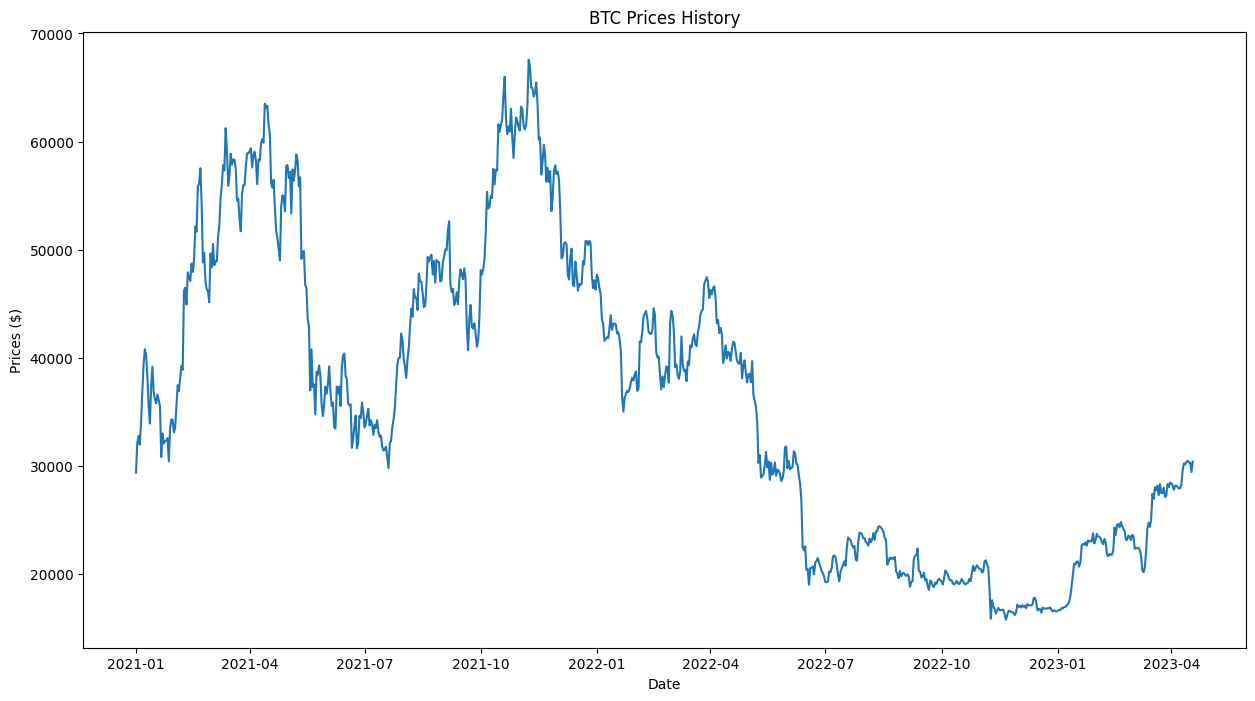

In [30]:
plt.figure(figsize=(15, 8))
plt.title('BTC Prices History')
plt.plot(BTC_quant['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [34]:
### Preparing training set (80%) ###
x_train = []
y_train = []
# Extract close price
close_price = BTC_quant['Adj Close']
training_data_len = math.ceil(len(close_price.values)* 0.8)
# Normalised data
scaled_data = MinMaxScaler(feature_range=(0,1)).fit_transform(close_price.values.reshape(-1,1))
training_data = scaled_data[0: training_data_len, :]

In [35]:
### Create a price window with 30 days ###
window_size = 30
for i in range(window_size, len(training_data)):
    x_train.append(training_data[i-window_size:i, 0])
    y_train.append(training_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [41]:
### Preparing testing set (20%) ###
test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = close_price.values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
### Set up LSTM architecture ###
model = keras.Sequential()
model.add(layers.LSTM(250, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(250, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 250)           252000    
                                                                 
 lstm_1 (LSTM)               (None, 250)               501000    
                                                                 
 dense (Dense)               (None, 25)                6275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 759,301
Trainable params: 759,301
Non-trainable params: 0
_________________________________________________________________


In [38]:
### Traning ###
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=50)

Epoch 1/50
641/641 [==============================] - 55s 79ms/step - loss: 0.0027
Epoch 2/50
641/641 [==============================] - 46s 71ms/step - loss: 0.0020
Epoch 3/50
641/641 [==============================] - 48s 74ms/step - loss: 0.0019
Epoch 4/50
641/641 [==============================] - 48s 75ms/step - loss: 0.0020
Epoch 5/50
641/641 [==============================] - 50s 77ms/step - loss: 0.0019
Epoch 6/50
641/641 [==============================] - 47s 73ms/step - loss: 0.0017
Epoch 7/50
641/641 [==============================] - 47s 74ms/step - loss: 0.0017
Epoch 8/50
641/641 [==============================] - 48s 74ms/step - loss: 0.0017
Epoch 9/50
641/641 [==============================] - 48s 74ms/step - loss: 0.0017
Epoch 10/50
641/641 [==============================] - 49s 77ms/step - loss: 0.0014
Epoch 11/50
641/641 [==============================] - 48s 75ms/step - loss: 0.0016
Epoch 12/50
641/641 [==============================] - 49s 77ms/step - loss: 0.0016
E

In [42]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6/6 [==============================] - 1s 54ms/step


400.59647501871257

<ipython-input-46-3b523ad06932>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


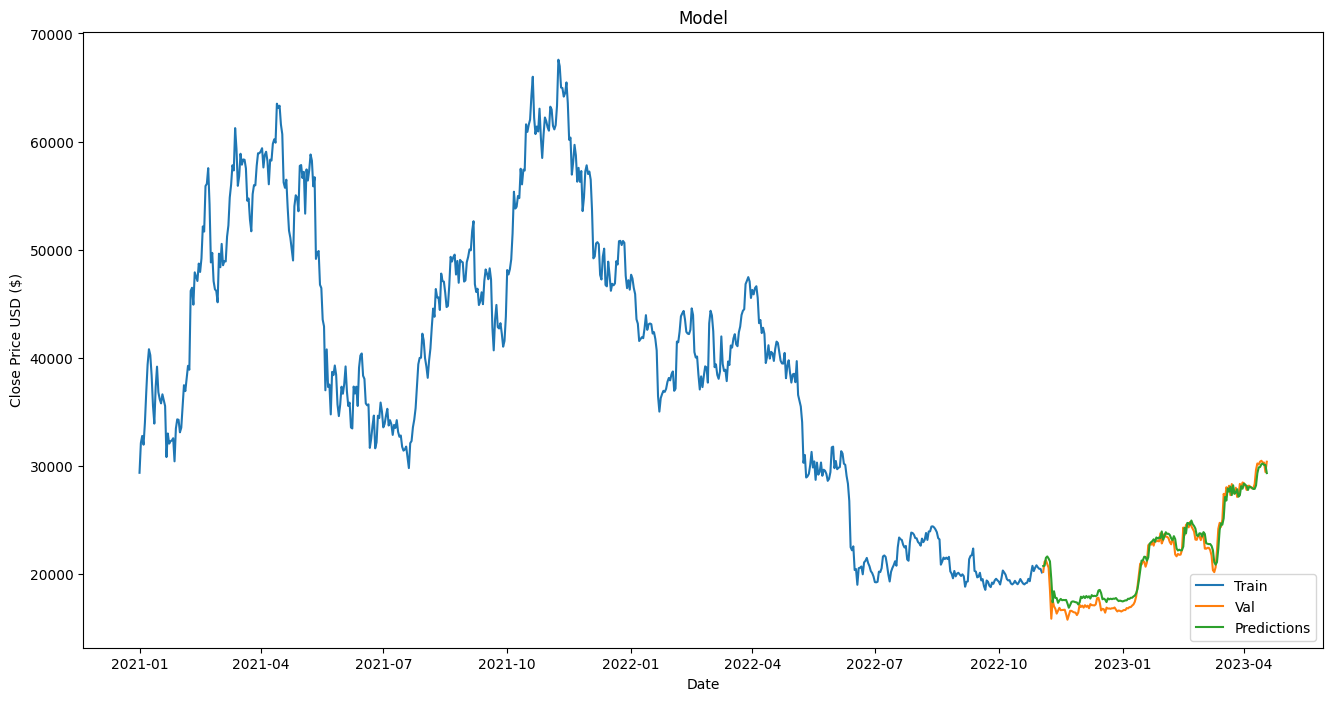

In [46]:
data = BTC_quant.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()